In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO009400497,107,2018-11-21 11:09:20.703,758,Uduwalla Pharmacy,Western Province,Colombo,Gothatuwa,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,29,Caltamin D Tabs-60's,1.0,1315.8,1500.0,0.0,0.0,1315.8,2018,November,11,21,4,Wednesday,11
1,IN0061000242,0,2018-11-21 11:06:34.347,1970,Poly Clinic,Sabaragamuwa Province,Ratnapura,Embilipitiya,156,,10,Multi Pharma,243,Myotan 50mg 100's,2.0,948.7,1081.5,0.0,0.0,1897.4,2018,November,11,21,4,Wednesday,11
2,IN0061000242,0,2018-11-21 11:06:34.347,1970,Poly Clinic,Sabaragamuwa Province,Ratnapura,Embilipitiya,156,,10,Multi Pharma,502,Cilacar Tab's 10mg (30's),10.0,870.0,990.0,0.0,0.0,8700.0,2018,November,11,21,4,Wednesday,11
3,CSO009400484,107,2018-11-21 11:37:10.273,741,Angoda Pharmacy,Western Province,Colombo,Angoda,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,20,Fastum Gel 30gm,10.0,501.8,572.0,0.0,0.0,5018.0,2018,November,11,21,4,Wednesday,11
4,CSO009400484,107,2018-11-21 11:37:10.273,741,Angoda Pharmacy,Western Province,Colombo,Angoda,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,20,Fastum Gel 30gm,0.0,501.8,572.0,2.0,2.0,0.0,2018,November,11,21,4,Wednesday,11


### Select the most selling product to identify the time series prediction

In [6]:
# select product sales records 
#Belcid Suspension 240ml top 1 product - based on unit qty
Pro1_invoice_All = invoice_All.loc[invoice_All['ItemUID'] == 25]

In [12]:
Pro1_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour,Year_Week,Month_Start
9,IN0061000242,0,2018-11-21 11:06:34.347,1970,Poly Clinic,Sabaragamuwa Province,Ratnapura,Embilipitiya,156,,10,Multi Pharma,25,Belcid Suspension 240ml,24.0,238.7,272.0,0.0,0.0,5728.8,2018,November,11,21,4,Wednesday,11,2018-46,2018-11-01
10,IN0061000242,0,2018-11-21 11:06:34.347,1970,Poly Clinic,Sabaragamuwa Province,Ratnapura,Embilipitiya,156,,10,Multi Pharma,25,Belcid Suspension 240ml,0.0,238.7,272.0,2.0,7.0,0.0,2018,November,11,21,4,Wednesday,11,2018-46,2018-11-01
13,CSO009000457,108,2018-11-21 13:08:11.017,1373,Galewela New Pharmacy,Central Province,Matale,Galewela,90,Dinesh Indika,7,Isuru Pharmaceuticals,25,Belcid Suspension 240ml,10.0,238.7,272.0,0.0,0.0,2387.0,2018,November,11,21,4,Wednesday,13,2018-46,2018-11-01
14,CSO009000457,108,2018-11-21 13:08:11.017,1373,Galewela New Pharmacy,Central Province,Matale,Galewela,90,Dinesh Indika,7,Isuru Pharmaceuticals,25,Belcid Suspension 240ml,0.0,238.7,272.0,3.0,3.0,0.0,2018,November,11,21,4,Wednesday,13,2018-46,2018-11-01
16,CSO009000465,108,2018-11-21 14:14:32.280,1372,Sugath Pharmacy,Central Province,Matale,Dambulla,90,Dinesh Indika,7,Isuru Pharmaceuticals,25,Belcid Suspension 240ml,10.0,238.7,272.0,0.0,0.0,2387.0,2018,November,11,21,4,Wednesday,14,2018-46,2018-11-01


In [11]:
 #get date from date time
Pro1_invoice_All['Month_Start'] = Pro1_invoice_All['Date'].to_numpy().astype('datetime64[M]')

<ipython-input-11-c4fbec0aed88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pro1_invoice_All['Month_Start'] = Pro1_invoice_All['Date'].to_numpy().astype('datetime64[M]')


In [13]:
Pro1_inv_grp = Pro1_invoice_All.groupby("Month_Start").agg({'UnitQty':'sum'}).reset_index()

In [14]:
Pro1_inv_grp 

,Month_Start,UnitQty
0,2018-11-01,37846.0
1,2018-12-01,29781.0
2,2019-01-01,30261.0
3,2019-02-01,29913.0
4,2019-03-01,25340.0
5,2019-04-01,22598.0
6,2019-05-01,43593.0
7,2019-06-01,28607.0
8,2019-07-01,24155.0
9,2019-08-01,24771.0


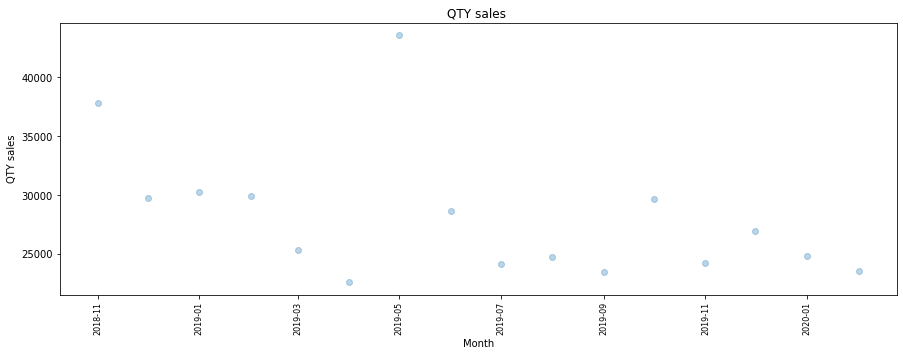

In [16]:
plt.scatter(Pro1_inv_grp.Month_Start , Pro1_inv_grp.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Month")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY sales")
plt.title("QTY sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

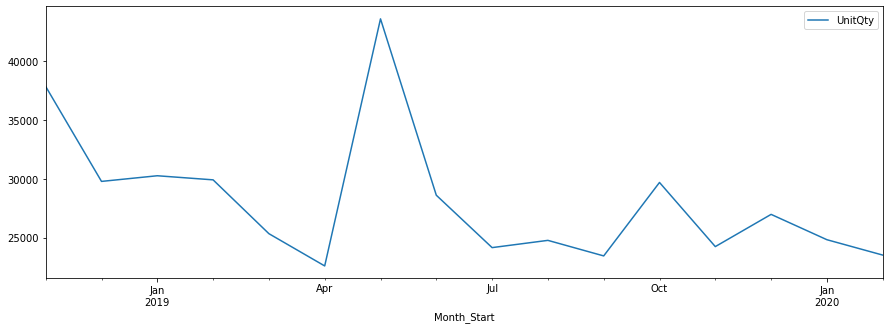

In [17]:
Pro1_inv_grp.plot(kind = 'line', x = 'Month_Start', y = 'UnitQty')
plt.show()

In [18]:
# remove z score > 3 
Pro1_inv_grp = Pro1_inv_grp[(np.abs(stats.zscore(Pro1_inv_grp["UnitQty"])) < 3)]

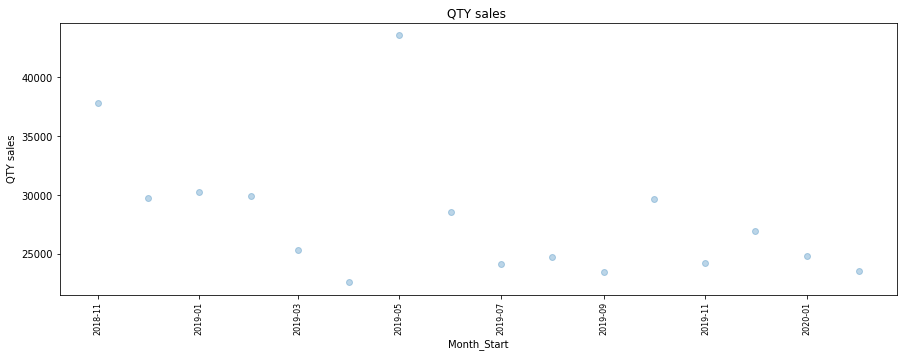

In [19]:
plt.scatter(Pro1_inv_grp.Month_Start , Pro1_inv_grp.UnitQty , alpha=0.3,cmap='viridis')
plt.xlabel("Month_Start")
plt.xticks (rotation='vertical', size=8)
plt.ylabel("QTY sales")
plt.title("QTY sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

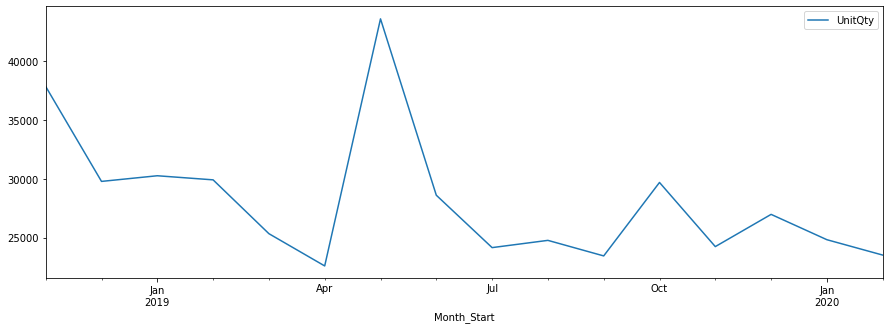

In [20]:
Pro1_inv_grp.plot(kind = 'line', x = 'Month_Start', y = 'UnitQty')
plt.show()

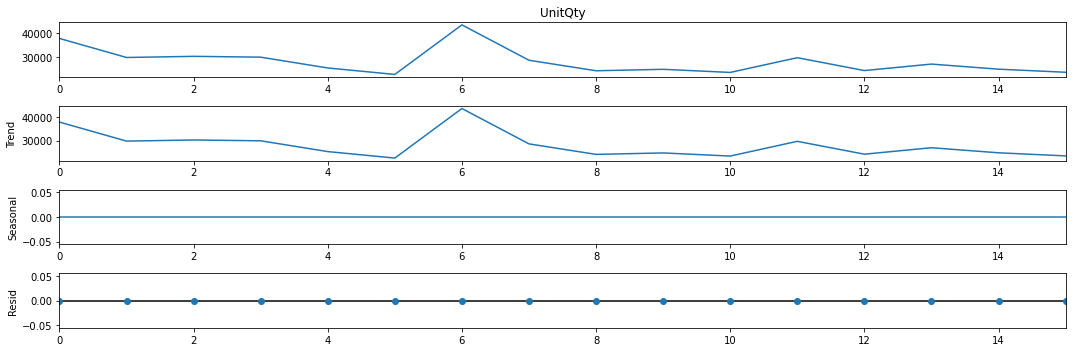

In [23]:
decomposition = seasonal_decompose(Pro1_inv_grp['UnitQty'], period =1)
decomposition.plot()
plt.show()

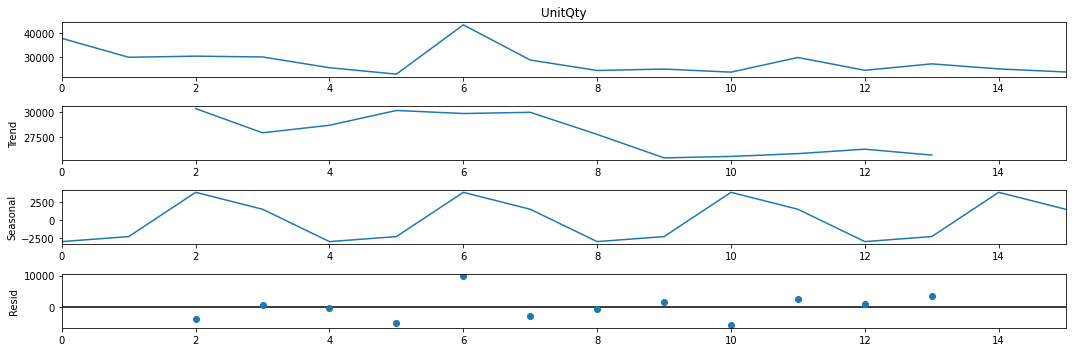

In [24]:
decomposition = seasonal_decompose(Pro1_inv_grp['UnitQty'], period =4)
decomposition.plot()
plt.show()

In [25]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Pro1_inv_grp['UnitQty'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -6.536608e+00
p-value                        9.573860e-09
#Lags Used                     6.000000e+00
Number of Observations Used    9.000000e+00
Critical Value (1%)           -4.473135e+00
Critical Value (5%)           -3.289881e+00
Critical Value (10%)          -2.772382e+00
dtype: float64


In [26]:
Pro1_inv_grp = Pro1_inv_grp.sort_index()
Pro1_inv_grp.head(50)

,Month_Start,UnitQty
0,2018-11-01,37846.0
1,2018-12-01,29781.0
2,2019-01-01,30261.0
3,2019-02-01,29913.0
4,2019-03-01,25340.0
5,2019-04-01,22598.0
6,2019-05-01,43593.0
7,2019-06-01,28607.0
8,2019-07-01,24155.0
9,2019-08-01,24771.0


In [27]:
#Pro1_inv_Nor_Sm = Pro1_inv_Nor_Sm.reset_index()
train = Pro1_inv_grp.loc[Pro1_inv_grp['Month_Start'] <= "2019-11-30"]
train = train.set_index('Month_Start')
test = Pro1_inv_grp.loc[Pro1_inv_grp['Month_Start'] > "2019-11-30"]
test = test.set_index('Month_Start')

In [28]:
from pmdarima import auto_arima
model = auto_arima(train.UnitQty, test='adf', trace=True)
results = model.fit(train.UnitQty)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=243.974, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=242.261, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=238.997, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=240.914, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=243.204, Time=0.02 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.519 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   13
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -117.498
Date:                Fri, 08 Apr 2022   AIC                            238.997
Time:                        19:50:44   BIC                            239.792
Sample:                             0   HQIC                           238.495
                                 - 13                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8196      0.372     -2.201      0.028      -1.549      -0.090
sigma2      1.358e+08    1.3e-09   1.05e+17      0.000    1.36e+08    1.36e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.79   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.18   Prob(JB):                         0.46
Heteroskedasticity (H):               0.35   Skew:                             0.80
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.2e+32. Standard errors may be unstable.
"""

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['UnitQty'],
                order=(0,2,1),seasonal_order=(0,0,0,0))
results = model.fit(disp=0)
results.summary()

c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                UnitQty   No. Observations:                   13
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -117.498
Date:                Fri, 08 Apr 2022   AIC                            238.997
Time:                        19:50:58   BIC                            239.792
Sample:                    11-01-2018   HQIC                           238.495
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8196      0.372     -2.201      0.028      -1.549      -0.090
sigma2      1.358e+08    1.3e-09   1.05e+17      0.000    1.36e+08    1.36e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.79   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.18   Prob(JB):                         0.46
Heteroskedasticity (H):               0.35   Skew:                             0.80
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.2e+32. Standard errors may be unstable.
"""

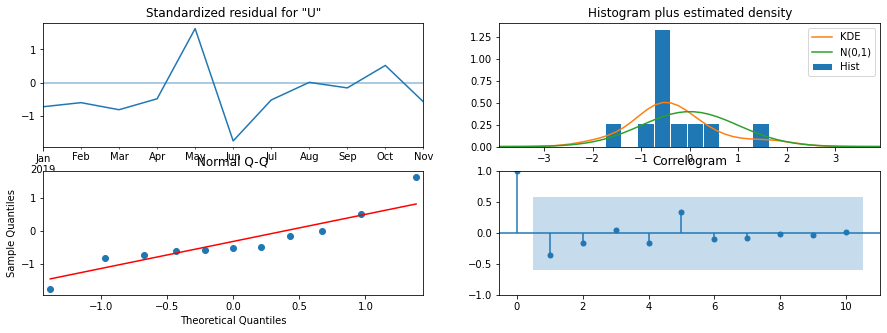

In [30]:
results.plot_diagnostics()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test_result = results.predict(start='2019-12-01', end='2020-02-01')
mse = mean_squared_error(test, test_result)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 1651.550426


#### Since this is quiet high value for RMSE the model is not best to predict.

In [35]:
test

,UnitQty
Month_Start,
2019-12-01,26979.0
2020-01-01,24827.0
2020-02-01,23521.0


In [33]:
test_result

2019-12-01    24310.472379
2020-01-01    24379.944759
2020-02-01    24449.417138
Freq: MS, Name: predicted_mean, dtype: float64

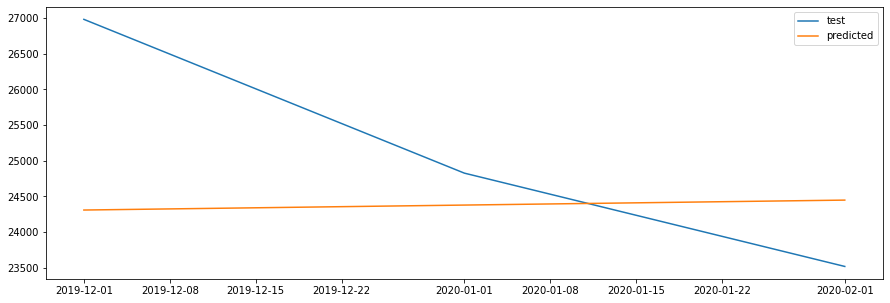

In [36]:
plt.plot(test)
plt.plot(test_result)
plt.legend(['test', 'predicted'])